In [ ]:
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging


import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [27]:
def lemmatize(text):
  lemmatizer = WordNetLemmatizer()
  r = re.sub('[^a-zA-Z]', ' ', text)
  r = r.lower()
  r= r.split()
  r = [word for word in r if word not in stopwords]
  r = [lemmatizer.lemmatize(word) for word in r]
  r = ' '.join(r)
  return r


def add_features(df):
  df['char_count'] = df['text'].apply(len) # Number of characters in the string
  df['word_count'] = df['text'].apply(lambda x: len(x.split())) # Number of words in the string
  df['word_density'] = df['char_count'] / (df['word_count']+1) # Density of word (in char)
  #df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
  df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
  df['text']= df['text'].apply(lemmatize)
  df['modified_word_count'] = df['text'].apply(lambda x: len(x.split())) # Number of words in the string
  return df

def get_data(train_path, test_path, random_seed):
    """
    function to read dataframe with columns
    """
    train_df = pd.read_json(train_path, lines=True)
    test_df = pd.read_json(test_path, lines=True)
    train_df, test_df= add_features(train_df), add_features(test_df)

    train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=random_seed)

    return train_df, val_df, test_df

train_path= '/content/SemEval2024-task8/SubtaskA/subtaskA_train_monolingual.jsonl'
test_path=  '/content/SemEval2024-task8/SubtaskA/subtaskA_dev_monolingual.jsonl'
random_seed = 0

train_df, valid_df, test_df = get_data(train_path, test_path, random_seed)
train_df.head()

,text,label,model,source,id,char_count,word_count,word_density,title_word_count
43234,Review of “Unsupervised Perceptual Rewards for...,1,chatGPT,peerread,43234,2615,387,6.739691,23
10382,"John Junkin (born August 17, 1982) is an Ameri...",1,chatGPT,wikipedia,10382,1421,222,6.372197,65
25869,\n\nWe report on the observation of ground-sta...,1,cohere,arxiv,25869,1020,168,6.035503,12
100005,[This interactive from the *New York Times*](_...,0,human,reddit,100005,4542,785,5.778626,70
69669,"If you are older, weaker, frailer, or younger...",0,human,wikihow,69669,13660,2549,5.356863,143


In [31]:
text.values[0]

'review unsupervised perceptual reward imitation learning paper author highlight challenge reward function design one main obstacle deployment reinforcement learning rl agent real world author propose novel approach infer perceptual reward function quickly small number demonstration leveraging abstraction power intermediate visual representation learned deep model key novelty approach ability identify key intermediate step task automatically identify discriminative feature identify step without using explicit sub goal supervision demonstrate efficacy approach presenting qualitative result two real world task quantitative evaluation human designed reward function show approach applied learn complex real world door opening skill using real robot video human performing task overall paper present compelling idea result obtained experiment demonstrate effectiveness proposed approach author provide clear concise description method technical detail explained precise comprehensible manner auth

In [23]:
train_df.label.value_counts(),  valid_df.label.value_counts(), test_df.label.value_counts()

(0    50680
 1    45125
 Name: label, dtype: int64,
 0    12671
 1    11281
 Name: label, dtype: int64,
 1    2500
 0    2500
 Name: label, dtype: int64)

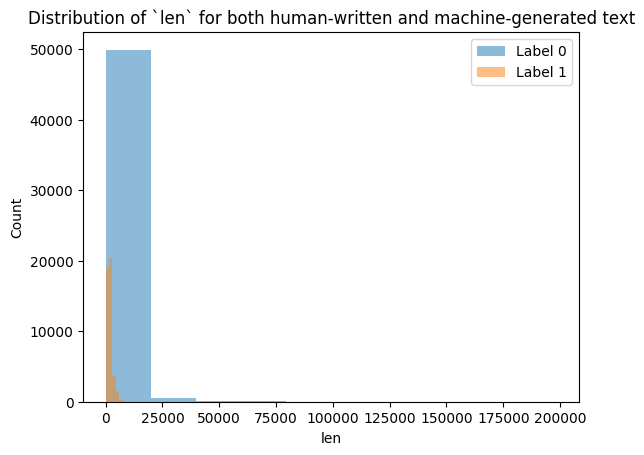

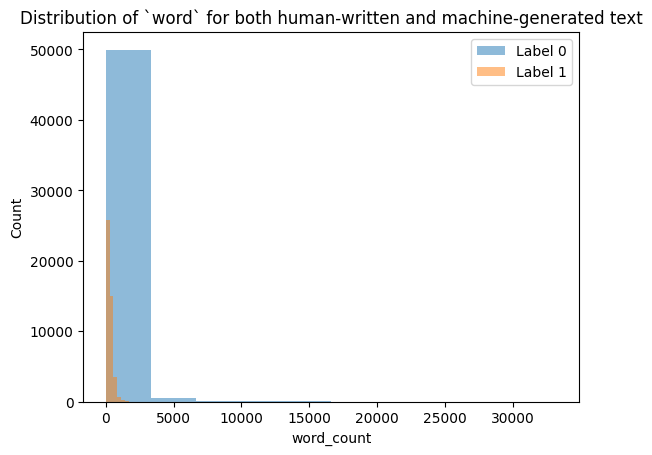

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt

def plot_distribution(df, column, labels, title):
    fig, ax = plt.subplots()

    for label in labels:
        ax.hist(df[df['label'] == label][column], label=f'Label {label}', alpha=0.5)

    ax.set_title(title)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.legend()
    plt.show()

# Assuming 0 represents human-written and 1 represents machine-generated
# Plot the distribution of the `len` column for both human-written and machine-generated 'text' on a single plot
plot_distribution(train_df, 'len', [0, 1], 'Distribution of `len` for both human-written and machine-generated 'text'')

plot_distribution(train_df, 'word_count', [0, 1], 'Distribution of `word` for both human-written and machine-generated 'text'')


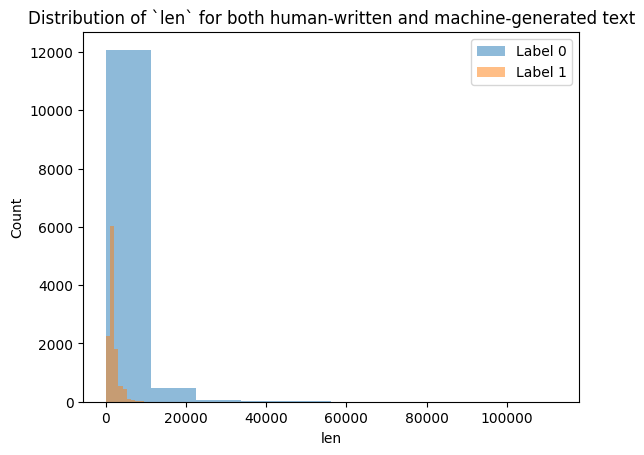

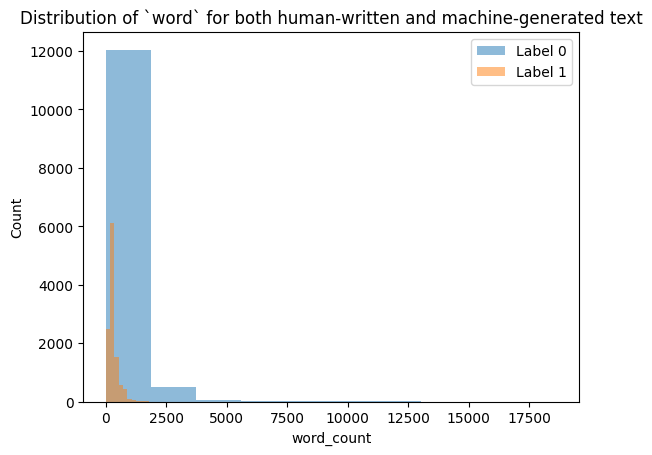

In [17]:
valid_df['len']= valid_df[''text''].str.len()
valid_df["word_count"] = valid_df[''text''].apply(lambda n: len(n.split()))
# Plot the distribution of the `len` column for both human-written and machine-generated 'text' on a single plot
plot_distribution(valid_df, 'len', [0, 1], 'Distribution of `len` for both human-written and machine-generated 'text'')

plot_distribution(valid_df, 'word_count', [0, 1], 'Distribution of `word` for both human-written and machine-generated 'text'')


In [7]:
train_dataset = Dataset.from_pandas(train_df)
train_dataset

Dataset({
    features: ['text', 'label', 'model', 'source', 'id', '__index_level_0__'],
    num_rows: 95805
})

In [9]:
def preprocess_function(examples, **fn_kwargs):
    return fn_kwargs['tokenizer'](examples["'text'"], truncation=True)
model='xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model)     # put your model here
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, fn_kwargs={'tokenizer': tokenizer})
tokenized_train_dataset

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/95805 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'model', 'source', 'id', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 95805
})

#Task A

In [ ]:
python3 subtaskA/baseline/transformer_baseline.py \
 --train_file_path /content/SemEval2024-task8/SubtaskA/subtaskA_train_monolingual.jsonl \
--test_file_path /content/SemEval2024-task8/SubtaskA/subtaskA_dev_monolingual.jsonl \
--prediction_file_path /content/SemEval2024-task8/SubtaskA/ \
--subtask A --model 'xlm-roberta-base'


2023-11-23 21:02:57.965317: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 21:02:57.981392: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 21:02:57.981497: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 21:03:00.923228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifi

#Task B

In [ ]:
!python3 subtaskB/baseline/transformer_baseline.py \
--train_file_path /content/SemEval2024-task8/SubtaskB/subtaskB_train.jsonl \
--test_file_path /content/SemEval2024-task8/SubtaskB/subtaskB_dev.jsonl \
 --prediction_file_path /content/SemEval2024-task8/SubtaskB  \
 --subtask B \
--model 'xlm-roberta-base'



2023-11-23 21:13:46.683960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 21:13:46.684042: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 21:13:46.684110: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 21:13:49.319013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/SemEval2024-task8/subtaskB/baseline/transformer_baseline.py", line 172, in <module>
    fine_tune(train_df, valid_df, f"{model}/subtask{subtask}/{random_seed}", id2label, label2id, model